In [73]:
import numpy as np 
from collections import defaultdict

import algorithms, features, environments
from algorithms import ELSTD, LSTD
from environments.policy import RandomPolicy
from environments.gridworld import Gridworld
from features.features import *

In [2]:
import matplotlib.pyplot as plt 
import matplotlib.cm as cm 
%matplotlib inline

In [44]:
def only_start(val):
    start_flag = True
    def func(*args):
        nonlocal start_flag
        if start_flag:
            start_flag = False
            return val
        else:
            return 0.0
    return func
    
def only_unseen(val):
    seen = set()
    def func(s, *args):
        nonlocal seen
        x = tuple(s)
        if x not in seen:
            seen.add(x)
            return val
        else:
            return 0.0
    return func
    
def decaying(x, decay):
    def decay_gen(val, decay):
        while True:
            yield val
            val = val*decay
    
    gen = decay_gen(x, decay)
    def func(*args):
        return next(gen)
    
    return func


def constant(val):
    """A factory for constant values for parameters."""
    def func(*args):
        return val
    return func

In [74]:
def apply_fa(episodes, phi_func):
    """Apply function approximation to a series of episodes."""
    ret = []
    for episode in episodes:
        tmp = []
        for step in episode[:-1]:
            s, a, r, sp = step
            fvec   = phi_func(s)
            fvec_p = phi_func(sp)
            tmp.append((fvec, a, r, fvec_p))
        # Account for final step of the episode
        s, a, r, sp = episode[-1]
        fvec   = phi_func(s)
        fvec_p = np.zeros(phi_func.length, dtype=np.float)
        tmp.append((fvec, a, r, fvec_p))
        ret.append(tmp)
    return ret


def run_episode(episode, agent, param_funcs):
    """
    Run an agent through an episode with state-dependent parameters.
    """
    # Dictionary containing information about the run
    dct = defaultdict(list)
    # Reset for start of episode
    agent.reset()
    for step in episode[:-1]:
        s, a, r, sp = step

        # State dependent parameters
        params = {}
        for k, func in param_funcs.items():
            params[k] = func(s)
        # Update the agent
        agent.update(s, r, sp, params)
        
        # Record information about timestep
        for k, v in params.items():
            dct[k].append(v)
        dct['s'].append(s)
        dct['a'].append(s)
        dct['r'].append(r)
        dct['sp'].append(sp)
        dct['z'].append(agent.z)
        dct['F'].append(agent.F)
        dct['M'].append(agent.M)

    # Final timestep update
    s, a, r, sp = episode[-1]
    sp = np.zeros_like(s, dtype=np.float)
    params = {}
    for k, func in param_funcs.items():
        params[k] = func(s)
        
    agent.update(s, r, sp, params)
    
    # Record information about timestep
    for k, v in params.items():
        dct[k].append(v)
    dct['s'].append(s)
    dct['a'].append(s)
    dct['r'].append(r)
    dct['sp'].append(sp)
    dct['z'].append(agent.z)
    dct['F'].append(agent.F)
    dct['M'].append(agent.M)

    return dct


def make_episodes(num_episodes, env, policy):
    return [make_episode(env, policy) for i in range(num_episodes)]
    

def make_episode(env, policy):
    env.reset()
    ret = []
    while not env.is_terminal():
        # Observe, take action, get next observation, and compute reward
        s  = env.observe()
        a  = policy(s)
        r  = env.do(a)
        sp = env.observe()

        # Append step to episode trajectory
        ret.append((s, a, r, sp))
    return ret

We can run experiments via

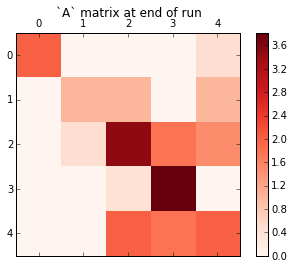

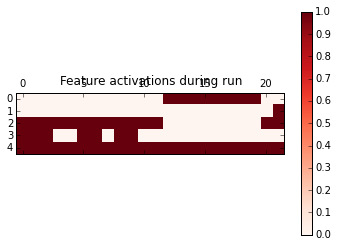

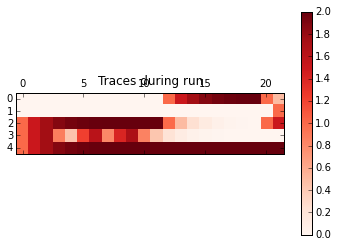

In [79]:
random_seed = 101
num_episodes = 1
nx, ny = 4, 2


# Initialize RNG
np.random.seed(random_seed)

# Setup environment
env = Gridworld(nx, ny, random_seed=random_seed)

# Setup policy
policy = RandomPolicy(env, random_seed=random_seed)

# Generate data
_episodes = make_episodes(num_episodes, env, policy)

# Apply function approximation
phi0 = Identity(len(env.observe()))
phi1 = Bias()
phi  = Combination((phi0, phi1))
episodes = apply_fa(_episodes, phi)

# Setup agents
elstd = algorithms.ELSTD(phi.length)

# Setup agent parameters
param_funcs = {'gamma': constant(1.0), 
                'interest': decaying(1.0, 0.5), 
                'lmbda': constant(0.5)}

# Run the experiment
dct = run_episode(episodes[0], elstd, param_funcs)

# Plot results
fig, ax = plt.subplots()
cax = ax.matshow(elstd.A, cmap=cm.Reds, vmin=0, vmax=np.max(elstd.A))
cbar = fig.colorbar(cax)
ax.set_title("`A` matrix at end of run")

fvmat = np.array([x[0] for x in episodes[0]])
fig, ax = plt.subplots()
cax = ax.matshow(fvmat.T, cmap=cm.Reds, vmin=0, vmax=np.max(fvmat.T))
cbar = fig.colorbar(cax)
ax.set_title("Feature activations during run")

zmat = np.array(dct['z'])
fig, ax = plt.subplots()
cax = ax.matshow(zmat.T, cmap=cm.Reds, vmin=0, vmax=np.max(zmat.T))
cbar = fig.colorbar(cax)
ax.set_title("Traces during run")


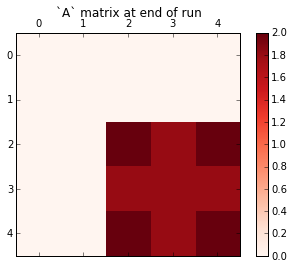

In [69]:
fig, ax = plt.subplots()
cax = ax.matshow(elstd.A, cmap=cm.Reds, vmin=0, vmax=np.max(elstd.A))
cbar = fig.colorbar(cax)
ax.set_title("`A` matrix at end of run")

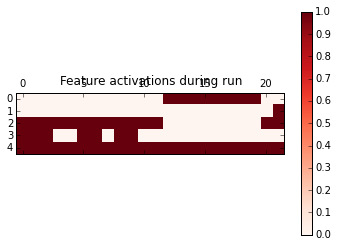

In [70]:
fvmat = np.array([x[0] for x in episodes[0]])
fig, ax = plt.subplots()
cax = ax.matshow(fvmat.T, cmap=cm.Reds, vmin=0, vmax=np.max(fvmat.T))
cbar = fig.colorbar(cax)
ax.set_title("Feature activations during run")

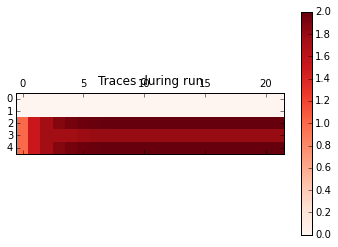

In [78]:
zmat = np.array(dct['z'])
fig, ax = plt.subplots()
cax = ax.matshow(zmat.T, cmap=cm.Reds, vmin=0, vmax=np.max(zmat.T))
cbar = fig.colorbar(cax)
ax.set_title("Traces during run")